# Recurrent Neural Network Demonstration

In this note book we will show a practical demonstration of recurrent neural networks. We will use an RNN to predict the future prices of a particular stock. Note: the purpose of this demonstration is to show how an RNN can be implemented. There are many other stock price prediction methods out there, and literature regarding the predictability of stock prices is present in abundance. Interested readers are encouraged to read those papers and decide for yourself whether machine learning for stock price prediction is an interesting reseach topic. 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import numpy as np

print(torch.cuda.is_available())

False


We will apply our model on minute-level prices of Amazon obtained on a particular day

In [2]:
#os.chdir("C:/Users/tonyz/Desktop/GRUVAE/data/usingmean") #set the directory of your data location
data = pd.read_csv("AMZN_put.csv").dropna()
data = data[["Stock"]]

#os.chdir("C:/Users/tonyz/Desktop/RNN notebook") #set the directory of your code location
from data_loader_LSTM_Options import create_inout_sequences

We will now split our data into training, validation and test sets, before putting them into a dataloader. We use 300 steps for training, 30 steps for validation, and 30 steps for prediction. Since we are doing forecasting in a supervised setting, we will use a lag value of 5. Feel free to print the shape of the input and outputs to get a better understanding.

In [3]:
train_steps = 300
val_steps = 30
tw = 5
pred_size = 30
train_size = train_steps/tw
validation_size = int(val_steps/tw)
test_size = int(len(data)//tw-train_size)
train_loader, test_loader,scaler = create_inout_sequences(data, tw, test_size)

/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/notebooks/data_loader_LSTM_Options.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  y_train = torch.tensor(y[:-test_size])


We will now code the most important section: the RNN implementation in Pytorch. In particular, we will implement a GRU model with a hidden size of 64. Switching to an LSTM model should be straightforward.

In [49]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=64, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True) #change this to nn.lstm for lstm model

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, inputs):
        
        _,lstm_out = self.lstm(inputs.view(1,len(inputs),1).float())
        lstm_out = lstm_out.view(1,-1)
        prediction = self.linear(lstm_out)
        return prediction

Our model will run faster on the GPU than on cpu so we will set our device to be "cuda". We will use the mean-squared-error loss function as our error metric. Our optimizer for gradient descent is ADAM with a learning rate of 0.005 and training for 50 epochs.

In [50]:
torch.manual_seed(0)
device = torch.device("cpu")
#device = torch.device("cuda")
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 50

We will now define a function which we will use for model training and evaluation. For model training in Pytorch, we have to specify model.train(), optimizer.zero_grad(), loss.backward() and optimizer.step(). These are standard procedures you have to include in your code for every project. When we evaluate the model, we have to specify with torch.no_grad(). We will save the model for after every epoch and compute the validation loss. We will then choose as our final model the one with the lowest validation error.

In [51]:
def train_and_val(epochs):
    models = []
    val_loss_list = []
    x = train_loader.dataset.tensors[0].to(device)
    y = train_loader.dataset.tensors[1].to(device)
    
    x2 = test_loader.dataset.tensors[0].to(device)
    y2 = test_loader.dataset.tensors[1].to(device)
    for j in range(epochs):
        train_loss = 0
        model.train()
        optimizer.zero_grad()
        for i in range(len(x)):
            print(y[i].float())
            y_pred = model(x[i])
            print(y[i].float())
            single_loss = loss_function(y_pred.float(), y[i].float().view(-1,1))
            train_loss += single_loss
        train_loss.backward()
        optimizer.step()
        copymodel = copy.deepcopy(model)
        models.append(copymodel)

        val_loss = nn.MSELoss()
        with torch.no_grad():
            model.eval()
            validation_x = x2[:validation_size]
            validation_y = y2[:validation_size]
            validation_loss = 0
            for k in range(len(validation_x)):
                prediction = model(validation_x[k])
                print(validation_y[k].view(-1,1).float())
                loss = val_loss(prediction.float(), validation_y[k].view(-1,1).float())
                validation_loss += loss
            val_loss_list.append(validation_loss.item())
        print(f"\tEpoch: {j}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")
    val, idx = min((val, idx) for (idx, val) in enumerate(val_loss_list))
    print(idx)
    return models[idx]

In [52]:
chosen_model = train_and_val(epochs).to("cpu")
test_x = test_loader.dataset.tensors[0][validation_size:]
test_y = test_loader.dataset.tensors[1][validation_size:]

tensor([1.9386])


AttributeError: 'tuple' object has no attribute 'view'

Recall that before training our RNN, we scaled our input data to make it easier for the neural network to perform gradient descent. After training our model, we now need to convert our predictions back to their original scale. This is done through the inverse function. 

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_85770/2155607970.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.cat([torch.tensor(y),torch.tensor(y)], dim=-1).numpy()
/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_85770/2155607970.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.cat([torch.tensor(y),torch.tensor(y)], dim=-1).numpy()


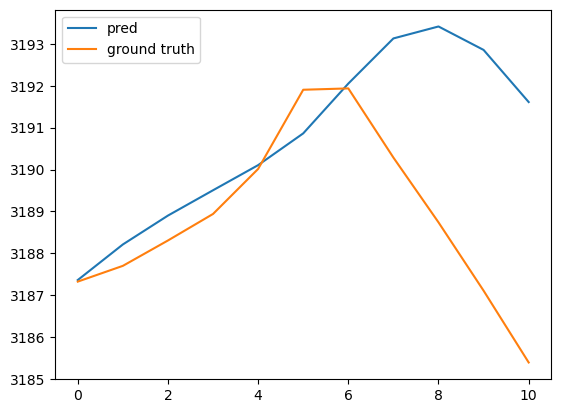

In [9]:
model.to("cpu")
test_predictions = []
tests = []
for i in range(len(test_x)):
    prediction = chosen_model(test_x[i]).view(-1).detach().tolist()
    test_predictions.append(prediction)
    test = test_y[i].tolist()
    tests.append(test)
    
def inverse(y, scaler):
    d = torch.cat([torch.tensor(y),torch.tensor(y)], dim=-1).numpy()
    d = scaler.inverse_transform(d)
    return d

test_predictions = inverse(torch.tensor(test_predictions).view(-1,1),scaler)[:,1][:pred_size]
tests = inverse(torch.tensor(tests).view(-1,1),scaler)[:,1][:pred_size]
plt.plot(test_predictions, label='pred');
plt.plot(tests, label='ground truth');
plt.legend();

We end by plotting the our predictions (orange) against the actual observed values. We see that for the first few steps our model does pretty well, however the performance drops quite siginificantly for the last few steps. Below is the code used to evluate the performance of a time series prediction model. Have a look at the formula for the normalised-mean-squared-error and the mean-absolute-percentage-error on wikipedia to make sure you understand what they are measuring.

In [10]:
def compute_nrmse(prediction,actual):
    #prediction = prediction.tolist()
    actual = actual.tolist()
    mse = []
    for i in range(len(prediction)):
       mse.append((prediction[i]-actual[i])**2)
    nrmse = ((sum(mse)/len(actual))**0.5)/np.mean(actual)
    return nrmse 

def compute_mape(prediction,actual):
    #prediction = prediction.tolist()
    actual = actual.tolist()
    mape = []
    for i in range(len(prediction)):
       mape.append(abs(actual[i]-prediction[i])/actual[i])  
    mape = sum(mape)/len(actual)
    return mape

In [11]:
compute_nrmse(test_predictions,tests)

0.0009620013031295479

In [12]:
compute_mape(test_predictions,tests)

0.0006394791482696197